### imports

In [1]:
import numpy as np
import itertools
from scipy.linalg import lu
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Recall determinant definition

From the lecture:

The determinant of a square matrix $A$ is defined as,
$$\det A = \sum_{\sigma \in S_n} \mathrm{sgn}({\sigma})\prod^n_{i=1} a_{i, \sigma_i}$$
where ,
- $S_n$ is the set of all **permutations** of the numbers $1, \ldots, n$,
- $\mathrm{sgn}$ is the **signature** of the permutation ( $(-1)^p$, where $p$ is the number of transpositions to be made).


# Alternative definition (from properties).

Determinant is a function $f: \mathbf{R}^{n \times n} \to \mathbf{R}$ such that
- $f(Id) = 1$
- $f(M)=-f(swap_{i,j}(M))$, where $swap_{i,j}$ swaps columns $i$ and $j$ in matrix
- $k \cdot f(M) = f(mul_{i}(M, k))$, where $mul_{i}$ multiplies $i$th column of matrix by k
- $f(M) = f(addcol_{i, j}(M))$, where $addcol_{i, j}$ adds column $j$ of matrix to column $i$.

This function exists and is unique (no proof)



# Row expansion (Laplace expansion)

The Laplace expansion, or cofactor expansion, is a method for calculating the determinant of a square matrix. This expansion can be applied along any row or column of the matrix.


$$
\det(A) = \sum_{j=1}^{n} (-1)^{i+j} a_{ij} \det(M_{ij})
$$

where $M_{ij}$ is the $((n-1) \times (n-1)$ minor matrix obtained by deleting the i-th row and j-th column from \( A \).


Proof:
By direct computation using the Leibniz formula




## Determinant of triangular matrix

Determinant of an upper-(lower-)triangular matrix $M$ is equal to $\prod_{i=1}^{n}M_{i,i}$.

Proof: row expansion

# Leibniz formula usage

In [2]:

def determinant_via_naive_calculation(matrix):
    n = matrix.shape[0]
    assert matrix.shape == (n, n), "Matrix must be square"

    # Generate all permutations of row indices
    permutations = itertools.permutations(range(n))
    det = 0

    for perm in permutations:
        # Compute the sign of the permutation
        sign = (-1) ** sum(perm[i] > perm[j] for i in range(n) for j in range(i + 1, n))

        # Compute the product of matrix elements for this permutation
        product = sign * np.prod([matrix[i, perm[i]] for i in range(n)])

        # Add to the determinant sum
        det += product

    return det


In [3]:
# Example usage
A = np.random.rand(5, 5)
print(determinant_via_naive_calculation(A))  # Determinant using Leibniz formula
print(np.linalg.det(A))

0.018970162772293877
0.018970162772293797


# Usage of row expansion

In [4]:
def determinant_via_row_expansion(matrix):
    # Base case for a 2x2 matrix
    assert len(matrix.shape) == 2
    assert matrix.shape[0] == matrix.shape[1]

    if matrix.shape == (2, 2):
        return matrix[0, 0] * matrix[1, 1] - matrix[0, 1] * matrix[1, 0]

    # Recursive case for larger matrices
    det = 0
    for col in range(matrix.shape[1]):
        # Create the minor matrix by excluding the current row and column
        minor = np.delete(matrix[1:], col, axis=1)
        # Calculate the cofactor
        cofactor = ((-1) ** col) * matrix[0, col] * determinant_via_row_expansion(minor)
        # Add the cofactor to the determinant
        det += cofactor

    return det

# Example usage
A = np.random.rand(5, 5)
print(determinant_via_row_expansion(A), 'Row expansion for determinant computation')
print(np.linalg.det(A), 'Library function')


0.02515300069567878 Row expansion for determinant computation
0.025153000695678815 Library function


# Simple, but time consuming...

  0%|          | 0/8 [00:00<?, ?it/s]

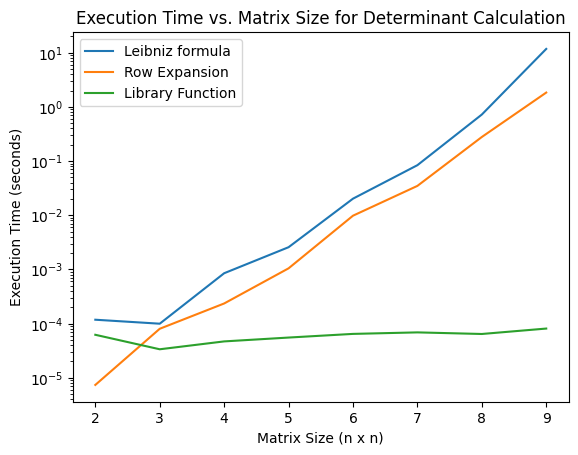

In [5]:


# Matrix sizes to test
matrix_sizes = list(range(2, 10))  # Sizes 2x2 to 7x7

# Arrays to store the execution times
time_naive = []
time_row_expansion = []
time_library_function = []

for size in tqdm(matrix_sizes):
    # Generate a random matrix of the current size
    matrix = np.random.rand(size, size)

    # Measure execution time of custom functions
    start_time = time.time()
    determinant_via_naive_calculation(matrix)
    time_naive.append(time.time() - start_time)

    start_time = time.time()
    determinant_via_row_expansion(matrix)
    time_row_expansion.append(time.time() - start_time)

    # Measure execution time of library function
    start_time = time.time()
    np.linalg.det(matrix)
    time_library_function.append(time.time() - start_time)

# Plotting the results
plt.plot(matrix_sizes, time_naive, label="Leibniz formula")
plt.plot(matrix_sizes, time_row_expansion, label="Row Expansion")
plt.plot(matrix_sizes, time_library_function, label="Library Function")
plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs. Matrix Size for Determinant Calculation")
plt.yscale('log')
plt.legend()
plt.show()

# How can we fix

In [6]:
def determinant_via_lu(matrix):
    # Perform LU decomposition
    P, L, U = lu(matrix)

    # Compute the determinant of A
    # Determinant of A = det(P) * det(L) * det(U)
    # Since P is a permutation matrix, det(P) is either 1 or -1
    det_P = np.linalg.det(P)
    det_L = np.prod(np.diag(L))  # Product of diagonal elements of L
    det_U = np.prod(np.diag(U))  # Product of diagonal elements of U

    # Compute the determinant of the original matrix
    return det_P * det_L * det_U

# Example usage
A = np.random.rand(5, 5)
print(determinant_via_lu(A))
print(np.linalg.det(A))  # For comparison


-0.023282732688192247
-0.023282732688192243


# And we can write LU by ourselves

In [7]:
def calc_decomp(matrix):
    n = matrix.shape[0]
    U = matrix.copy()
    L = np.eye(n)
    P = np.eye(n)
    num_swaps = 0  # Track number of row swaps

    for i in range(n):
        # Find pivot (max element in the current column)
        max_row = np.argmax(abs(U[i:, i])) + i

        # Swap rows in U if needed
        if i != max_row:
            U[[i, max_row]] = U[[max_row, i]]
            P[[i, max_row]] = P[[max_row, i]]
            L[[i, max_row], :i] = L[[max_row, i], :i]
            num_swaps += 1  # Increment swap count

        # Perform Gaussian elimination
        for j in range(i+1, n):
            factor = U[j, i] / U[i, i]
            U[j, i:] -= factor * U[i, i:]
            L[j, i] = factor

    return P, L, U, num_swaps




In [8]:
A = np.random.rand(5, 5)
p, l, u, num_swaps = calc_decomp(A)
assert np.allclose(p @ A, l @ u)

In [9]:
def determinant_via_lu_our(matrix):
    P, L, U, num_swaps = calc_decomp(matrix)

    # The determinant is the product of the diagonal elements of U
    det_U = np.prod(np.diag(U))


    det_L = np.prod(np.diag(L))
    assert det_L - 1 <= 1e-10, "L smth is wrong with our lu"

    # Adjust for the permutation matrix P (if there were an odd number of row swaps, flip the sign)
    det_P = (-1) ** num_swaps

    return det_P * det_U

# Example usage
A = np.random.rand(5, 5)
print(determinant_via_lu_our(A))  # Determinant using LU decomposition
print(np.linalg.det(A))       # Determinant using NumPy for comparison

0.1393609299343396
0.13936092993433963


# Let's benchmark once more...

  0%|          | 0/8 [00:00<?, ?it/s]

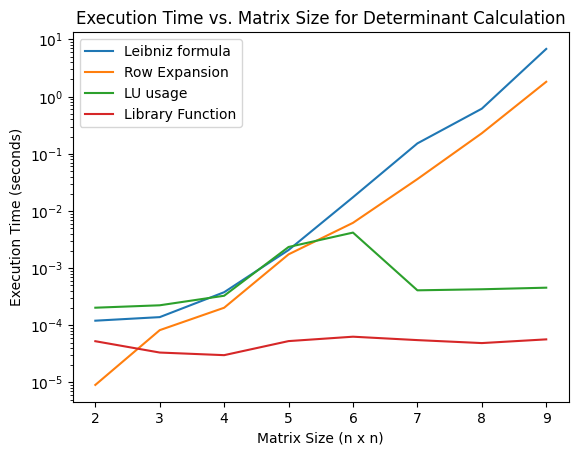

In [10]:


# Matrix sizes to test
matrix_sizes = list(range(2, 10))  # Sizes 2x2 to 7x7

# Arrays to store the execution times
time_naive = []
time_row_expansion = []
time_library_function = []
time_lu = []

for size in tqdm(matrix_sizes):
    # Generate a random matrix of the current size
    matrix = np.random.rand(size, size)

    # Measure execution time of custom functions
    start_time = time.time()
    determinant_via_naive_calculation(matrix)
    time_naive.append(time.time() - start_time)

    start_time = time.time()
    determinant_via_row_expansion(matrix)
    time_row_expansion.append(time.time() - start_time)

    start_time = time.time()
    determinant_via_lu_our(matrix)
    time_lu.append(time.time() - start_time)

    # Measure execution time of library function
    start_time = time.time()
    np.linalg.det(matrix)
    time_library_function.append(time.time() - start_time)

# Plotting the results
plt.plot(matrix_sizes, time_naive, label="Leibniz formula")
plt.plot(matrix_sizes, time_row_expansion, label="Row Expansion")
plt.plot(matrix_sizes, time_lu, label="LU usage")
plt.plot(matrix_sizes, time_library_function, label="Library Function")
plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs. Matrix Size for Determinant Calculation")
plt.yscale('log')
plt.legend()
plt.show()

In [11]:


# Matrix sizes to test
matrix_sizes = list(range(2, 400))

# Arrays to store the execution times
time_library_function = []
time_lu = []

for size in tqdm(matrix_sizes):
    # Generate a random matrix of the current size
    matrix = np.random.rand(size, size)

    # Measure execution time of custom functions
    start_time = time.time()
    determinant_via_lu_our(matrix)
    time_lu.append(time.time() - start_time)

    # Measure execution time of library function
    start_time = time.time()
    np.linalg.det(matrix)
    time_library_function.append(time.time() - start_time)

# Plotting the results

time_lu = np.array(time_lu)
time_library_function = np.array(time_library_function)

time_lu = time_lu / time_lu[0]
time_library_function = time_library_function / time_library_function[0]



  0%|          | 0/398 [00:00<?, ?it/s]

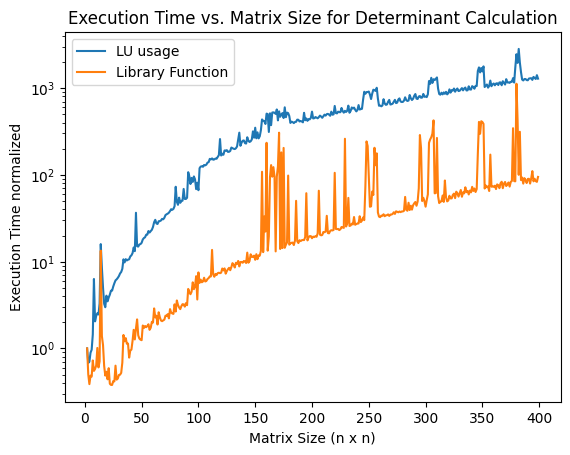

In [12]:
plt.plot(matrix_sizes, time_lu, label="LU usage")
plt.plot(matrix_sizes, time_library_function, label="Library Function")
plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Execution Time normalized")
plt.title("Execution Time vs. Matrix Size for Determinant Calculation")
plt.yscale('log')
plt.legend()
plt.show()

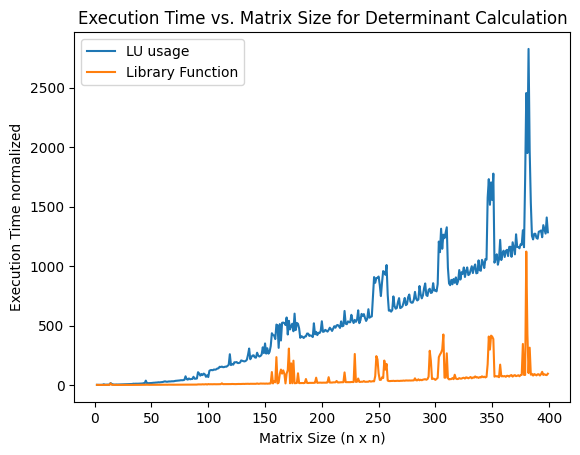

In [13]:
plt.plot(matrix_sizes, time_lu, label="LU usage")
plt.plot(matrix_sizes, time_library_function, label="Library Function")
plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Execution Time normalized")
plt.title("Execution Time vs. Matrix Size for Determinant Calculation")
#plt.yscale('log')
plt.legend()
plt.show()

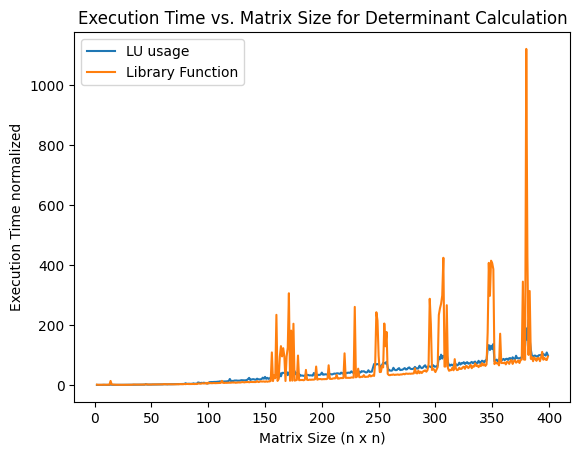

In [18]:
plt.plot(matrix_sizes, time_lu / 13, label="LU usage")
plt.plot(matrix_sizes, time_library_function, label="Library Function")
plt.xlabel("Matrix Size (n x n)")
plt.ylabel("Execution Time normalized")
plt.title("Execution Time vs. Matrix Size for Determinant Calculation")
#plt.yscale('log')
plt.legend()
plt.show()